# Building a Language Model with Pytorch

In this lab exercise, we'll build an LSTM language model using the WikiText dataset which can generate novel sentences.

Link to the notebook: https://tinyurl.com/y2zz2qu8
**Copy the notebook to your GDrive to edit.**

In [1]:
# magic commands to make sure changes to external packages are automatically loaded and plots are displayed in the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import random
import numpy as np
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
from torch.optim import Adam, RMSprop
import nltk

In [3]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

# RNNs

![Karpathy blog rnn example](https://karpathy.github.io/assets/rnn/diags.jpeg)

Source: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

Recurrent neural nets (RNNs) are a widely used neural network architecture for working with sequence data. As seen above, they can be used for a variety of problems which work with sequences. They are based on performing computations which consider both a given input and a **state**, which is updated at every step on the input sequence. How this state is kept and the internal calculations of an RNN can differ. There are generally three main types of RNN cells used in practice: vanilla RNNs, GRU, and LSTM. GRUs and LSTMs differ from vanilla RNNs in that they use **gating mechanisms** in order to mitigate vanishing gradients, which are a known problem with vanilla RNNs, and are better at capturing long-term dependencies. We will use the LSTM cell in this lab.

# Recap on Data Preparation for RNNs 
## Packing
We'll start with a recap of the steps to prepare textual input for training an RNN and we'll walk through an show-case of packing sequences.

In [4]:
# We want to run LSTM on a batch with 3 sentences
sents = ['The word of the Lord came to Zechariah son of Iddo the prophet.',  # len = 13
        'fruit flies like a banana',      # len = 5
        'Fruit flies live on a banana']    # len = 6

# Step 1: Construct Vocabulary
vocab = ['<pad>'] + sorted(set([token for sent in sents for token in sent.split()]))

#Step 2: Load indexed data (list of instances, where each instance is list of character indices)
vectorized_seqs = [[vocab.index(tok) for tok in sent.split()]for sent in sents]

#Step 3: Make Model
embed = torch.nn.Embedding(len(vocab), 4) # embedding_dim = 4
lstm = torch.nn.LSTM(input_size=4, hidden_size=5, batch_first=True) # input_dim = 4, hidden_dim = 5

#Step 4: Pad instances with 0s till max length sequence
# get the length of each seq in your batch
seq_lengths = torch.LongTensor(list(map(len, vectorized_seqs)))

seq_tensor = torch.tensor(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()

for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
seq_tensor

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[ 4, 19, 13, 17,  3,  8, 18,  5, 16, 13,  2, 17, 15],
        [10,  9, 11,  6,  7,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  9, 12, 14,  6,  7,  0,  0,  0,  0,  0,  0,  0]])

In [32]:
# Step 5: Sort instances by sequence length in descending order 
# this step is not compulsory, where the packing functions have a parameter enforce_sorted, which can be set to False
seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
seq_tensor = seq_tensor[perm_idx]
seq_tensor

tensor([[ 4, 19, 13, 17,  3,  8, 18,  5, 16, 13,  2, 17, 15],
        [ 1,  9, 12, 14,  6,  7,  0,  0,  0,  0,  0,  0,  0],
        [10,  9, 11,  6,  7,  0,  0,  0,  0,  0,  0,  0,  0]])

In [33]:
# Calling pack_padded_sequence with instances and sequence lengths
# Here we give an idea of the packing functionality, 
# which is important for training RNN on text with variable lenght
packed_input = torch.nn.utils.rnn.pack_padded_sequence(seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)
# packed_input (PackedSequence is NamedTuple with 2 attributes: data and batch_sizes
packed_input

PackedSequence(data=tensor([ 4,  1, 10, 19,  9,  9, 13, 12, 11, 17, 14,  6,  3,  6,  7,  8,  7, 18,
         5, 16, 13,  2, 17, 15]), batch_sizes=tensor([3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [34]:
# Step 6: Let's now proceed with the network transformations and embed the instances
embedded_seq_tensor = embed(seq_tensor)
embedded_seq_tensor

tensor([[[ 1.6423, -0.1596, -0.4974,  0.4396],
         [ 0.5750, -0.6417, -2.2064, -0.7508],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [ 0.3466, -0.1973, -1.0546,  1.2780],
         [-0.7279, -0.5594, -0.7688,  0.7624],
         [-1.3847, -0.8712, -0.2234,  1.7174],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-0.7581,  1.0783,  0.8008,  1.6806],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.7521,  1.6487, -0.3925, -1.4036],
         [ 0.3466, -0.1973, -1.0546,  1.2780],
         [-0.0978,  1.8446, -1.1845,  1.3835]],

        [[ 0.6784, -1.2345, -0.0431, -1.6047],
         [ 0.3189, -0.4245,  0.3057, -0.7746],
         [-0.9138, -0.6581,  0.0780,  0.5258],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 

In [35]:
# Step 7: Call pack_padded_sequence with embeded instances and sequence lengths
packed_input = torch.nn.utils.rnn.pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)
# packed_input (PackedSequence is NamedTuple with 2 attributes: data and batch_sizes
packed_input

PackedSequence(data=tensor([[ 1.6423, -0.1596, -0.4974,  0.4396],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-1.5576,  0.9956, -0.8798, -0.6011],
        [ 0.5750, -0.6417, -2.2064, -0.7508],
        [ 0.3189, -0.4245,  0.3057, -0.7746],
        [ 0.3189, -0.4245,  0.3057, -0.7746],
        [-0.4880,  1.1914, -0.8140, -0.7360],
        [-0.9138, -0.6581,  0.0780,  0.5258],
        [-1.2742,  2.1228, -1.2347, -0.4879],
        [ 0.3466, -0.1973, -1.0546,  1.2780],
        [-1.4032,  0.0360, -0.0635,  0.6756],
        [ 1.2791,  1.2964,  0.6105,  1.3347],
        [-0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.2791,  1.2964,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-1.3847, -0.8712, -0.2234,  1.7174],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-0.1722,  0.5238,  0.0566,  0.4263],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.4451,  0.8564,  2.2181,  0.5232],
        [-0.4880,  1.1914, -0.8140, -0.7360],
        [-0.75

In [36]:
# Step 8: Forward with LSTM
packed_output, (ht, ct) = lstm(packed_input)

# Step 9: Call unpack_padded_sequences if required / or just pick last hidden vector
output, input_sizes = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

Summary of Shape Transformations

(batch_size X max_seq_len X embedding_dim) --> Sort by seqlen ---> (batch_size X max_seq_len X embedding_dim)

(batch_size X max_seq_len X embedding_dim) --->      Pack     ---> (batch_sum_seq_len X embedding_dim)

(batch_sum_seq_len X embedding_dim)        --->      LSTM     ---> (batch_sum_seq_len X hidden_dim)

(batch_sum_seq_len X hidden_dim)           --->    UnPack     ---> (batch_size X max_seq_len X hidden_dim)


## Bucketing
Another useful trick when training NLP models is to group instances of similar lenghts in the same batch which leads to minimal padding, e.g. a batch with instances of lenght 5, 5, 6 will be padded to lenght 6, while a batch with instances of lenght 5, 5, 13 will be padded to lenght 13 and will also take more time for processing.

On the other hand, you still want some randomness in the batches and the ultimate solution would be to have buckets with N instances with similar lenght and shuffle them into K batches.

The Torch text library contains an example implementation for this purpose -- Bucket Iterator (https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator).

# Building a Language Model
Next, we'll build a Language Model with a RNN. Language Models are trained to assign probabilities to sequences of words. They can be used to verify how likely is a particular sequence of text, e.g. if it sounds grammatical and complies to the rules of a language. Language models predict the next word in a sequence given the past context. A best LM is one that best predicts unseen words. LMs are evaluated with Perplexity, which is the inverse probability of the test set, normalized by the number of words:

\begin{equation}
\mathrm{PP}(W)=\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P\left(w_{i} \mid w_{1} \ldots w_{i-1}\right)}}
\end{equation}

Minimizing perplexity is the same as maximising probability of the correct prediction.

# Upload the dataset 

For training the Language Model, we'll be using the [WikiText-2 dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving wiki.test.tokens to wiki.test.tokens
Saving wiki.train.tokens to wiki.train.tokens
Saving wiki.valid.tokens to wiki.valid.tokens
User uploaded file "wiki.test.tokens" with length 1256449 bytes
User uploaded file "wiki.train.tokens" with length 10797148 bytes
User uploaded file "wiki.valid.tokens" with length 1121681 bytes


# Read in the data

The dataset is already tokenized and split into test, validation and training datasets. 

For preprocessing, we don't have to take care of tokenization and will only replace new lines with an \<eos> token. 

We also have to take care of converting the text into sequences of ids with a vocabulary object that'll keep the mapping (in lab_02, we used a ready-made tokenizer, which also took care of converting the text to ids as the ids have to match the word ids in the embedding matrix provided by the same package)


In [5]:
class Vocab:
  def __init__(self):
    self.word2idx = {}
    self.idx2word = []

  def add_word(self, word):
    if word not in self.word2idx:
      self.idx2word.append(word)
      self.word2idx[word] = len(self.idx2word) - 1
    return self.word2idx[word]
    
  def to_words(self, ids):
    return [self.idx2word[idx] for idx in ids]

  def to_ids(self, words):
    return [self.add_word(word) for word in words]

  def __len__(self):
    return len(self.idx2word)

Next, we'll build the vocabulary with the words from the splits. 

As the dataset is relatively small, we can use only the words that appear in it. This way we can also customise whether we care about upper-case tokens or want all of them to be lower-case or to include domain-specific tokens.

In [6]:
vocabulary = Vocab()
vocabulary.add_word('<eos>') # include a token indicating the end of a string
vocabulary.add_word('<pad>') # include a token for padding

for filename in ['wiki.test.tokens', 'wiki.train.tokens', 'wiki.valid.tokens']:
  with open(filename) as out:
    for line in out:
      tokens = line.strip().split(' ')
      for token in tokens:
          vocabulary.add_word(token)

len(vocabulary)

33280

**Note.** If the dataset is large, we can use a standard list of tokens to build a vocabulary, e.g. the NLTK English vocabulary, which will results in a larger embedding matrix (NLTK contains 236736 tokens and our vocabulary is of 33278 tokens). We can also use the vocabulary of a tokenizer we employ for pre-processing.

In [7]:
from nltk.corpus import words
import nltk
nltk.download('words')
len(list(words.words()))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


236736

The dataset reader will read the whole file with Wikipedia pages and split the text to consecutive sequences of length seq_len, where each sequence will be one instance of the dataset. 

**Note.** One could also split first to different Wikipedia pages so that there aren't instances with text for different Wiki pages. 

In [8]:
!head -20 wiki.test.tokens 

 
 = Robert <unk> = 
 
 Robert <unk> is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John <unk> in 2002 . In 2004 <unk> landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> <unk> Factory in London . He was directed by John <unk> and starred alongside Ben <unk> , Shane <unk> , Harry Kent , Fraser <unk> , Sophie Stanton and Dominic Hall . 
 In 2006 , <unk> starred alongside <unk> in the play <unk> written by Mark <unk> . He appeared on a 2006 episode of the televisio

The dataset is loaded again using the Dataset class from PyTorch. There are different options for constructing the dataset, e.g. the different sentence can be counted as separate instances, we can also iterate through the whole dataset, or a wiki document with a window of size L and count each window as an instance.

In [117]:
class WikiDatasetReader(Dataset):
  def __init__(self, file_name: str, vocab: Vocab, seq_len: int):
    self.vocab = vocab

    text = open(file_name).read()
    text = text.replace('\n', '<eos>')

    # each document start with a title between two = signs, 
    # include <eos> to avoid matching subtitles (with more =)
    wiki_docs = re.split(' = [^=]+ = <eos>', text)

    self.dataset = []
    for document in wiki_docs:
      tokens = [token for token in document.split(' ') if len(token) > 0]

      if len(tokens) <= 1:
        # skip empty rows
        continue

      # iterate through the wiki document with a window of size seq_len
      # each window is a separate instance
      doc_instances = [tokens[i:i+seq_len] for i in range(0, len(tokens), seq_len)]

      # pad the last window, which can be shorted than seq_len
      doc_instances[-1] = doc_instances[-1] + ['<pad>'] * (seq_len - len(doc_instances[-1]))
      self.dataset.extend(doc_instances)
    
    # truncate last incomplete batch (the hidden states for the RNN have the shape of the batch)
    self.dataset = self.dataset[:(len(self.dataset)-(len(self.dataset) % batch_size))]

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx: int):
    return self.vocab.to_ids(self.dataset[idx])

In [118]:
seq_len = 35
batch_size = 128
test_dataset = WikiDatasetReader('wiki.test.tokens', vocabulary, seq_len)

print(test_dataset[0])
print(vocabulary.to_words(test_dataset[0]))
print()
print(test_dataset[1])
print(vocabulary.to_words(test_dataset[1]))

[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 11, 25, 26, 27, 28, 29, 15, 30, 31, 32, 33, 18, 21]
['<eos>', 'Robert', '<unk>', 'is', 'an', 'English', 'film', ',', 'television', 'and', 'theatre', 'actor', '.', 'He', 'had', 'a', 'guest', '@-@', 'starring', 'role', 'on', 'the', 'television', 'series', 'The', 'Bill', 'in', '2000', '.', 'This', 'was', 'followed', 'by', 'a', 'starring']

[22, 28, 24, 34, 35, 36, 33, 37, 38, 10, 39, 31, 40, 28, 41, 42, 24, 43, 44, 45, 15, 16, 17, 18, 19, 22, 28, 24, 11, 25, 46, 47, 5, 28, 48]
['role', 'in', 'the', 'play', 'Herons', 'written', 'by', 'Simon', 'Stephens', ',', 'which', 'was', 'performed', 'in', '2001', 'at', 'the', 'Royal', 'Court', 'Theatre', '.', 'He', 'had', 'a', 'guest', 'role', 'in', 'the', 'television', 'series', 'Judge', 'John', '<unk>', 'in', '2002']


In [119]:
def collate_batch_bilstm(input_ids: List) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_ids: The token input ids
    :return: A tuple of tensors (input_ids, targets)
    """
    input_data = torch.tensor(input_ids)
    # we don't use the last position as there isn't anything left for generation
    input_ids = input_data[:, :-1]
    # the target at each step is to generate the next word from the sequence
    # so we shift the token ids with 1 position
    targets = input_data[:, 1:]
    return input_ids, targets

In [120]:
collate_batch_bilstm([test_dataset[0]])

(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 11, 25, 26, 27, 28, 29, 15, 30, 31, 32, 33, 18]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
          22, 23, 24, 11, 25, 26, 27, 28, 29, 15, 30, 31, 32, 33, 18, 21]]))

In [121]:
val_dataset = WikiDatasetReader('wiki.valid.tokens', vocabulary, seq_len)
train_dataset = WikiDatasetReader('wiki.train.tokens', vocabulary, seq_len)

# Creating the model

Next we will create an LSTM model. We again extend the PyTorch class `torch.nn.Module` and implement the `__init__` function, and define how tensors are processed in the `__forward__` function.

**Question.** Why aren't we using a Bi-LSTM network for a Language Model?

In [122]:
# Define the model
class LSTMNetwork(nn.Module):
    """
    Basic LSTM network
    """
    def __init__(
            self,
            vocab_size: int, 
            embeddings_dim: int,
            lstm_dim: int,       
            n_words: int,      
            dropout_prob: float = 0.0,
            lstm_layers: int = 1,
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(LSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer LSTM, and a feed-forward output layer
        self.vocab_size = vocab_size
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding(vocab_size, embeddings_dim),
            'bilstm': nn.LSTM( 
                embeddings_dim,
                lstm_dim,
                num_layers=lstm_layers,
                batch_first=True,
                dropout=dropout_prob),
            'ff': nn.Linear(lstm_dim, vocab_size),
        })

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, input_ids, hidden_states):
        """
        Defines how tensors flow through the model
        :param input_ids: (b x sl) The IDs into the vocabulary of the input samples
        :param hidden_states: (b x sl) x 2 Hidden states for the LSTM model
        :return: (lstm output, updated hidden stated)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](input_ids)
      
        # Pass the sequence through the BiLSTM
        lstm_out, hidden_states = self.model['bilstm'](embeds, hidden_states)
        
        lstm_out = lstm_out.reshape(lstm_out.size(0)*lstm_out.size(1), lstm_out.size(2))
        lstm_out = self.model['ff'](lstm_out)

        return lstm_out, hidden_states

In [123]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

In [152]:
# Define some hyperparameters
lr = 0.001
n_epochs = 4
lstm_dim = 1024
lstm_layers = 1
embeddings_dim = 128

This is a utility function which will take a model and a validation dataloader and return the current perplexity of the model against that dataset. We can use this to know when to save the model and to perform early stopping if desired.

In [125]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  model.eval()
  loss_all = []
  states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
  loss_fn = nn.CrossEntropyLoss()
        
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      targets = batch[1]
      states = detach(states)
      logits, states = model(input_ids, states)
      loss = loss_fn(logits, targets.reshape(-1))

      loss_all.append(loss.detach().cpu().numpy())

  perplexity = np.exp(sum(loss_all) / (len(loss_all)))
  return perplexity

Here we define the main training loop.

In [126]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states]

def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_perplexity = 300.0
  # Set initial hidden and cell states
  loss_fn = nn.CrossEntropyLoss()
  # Iterate through epochs
  for ep in range(n_epochs):
    states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
 
    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      targets = batch[1]
      # Pass the inputs through the model, get the current loss and logits
      states = detach(states)
      logits, states = model(input_ids, states)
      loss = loss_fn(logits, targets.reshape(-1))

      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    perplexity = evaluate(model, valid_dl)
    print(f'Validation perplexity: {perplexity}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if perplexity < best_perplexity:
      best_model = model.state_dict()
      best_perplexity = perplexity

  model.load_state_dict(best_model)
  return model, losses

Now that we have the basic training and evaluation loops defined, we can create the datasets and optimizer and run it!

In [127]:
val_dataset = WikiDatasetReader('wiki.valid.tokens', vocabulary, seq_len)
train_dataset = WikiDatasetReader('wiki.train.tokens', vocabulary, seq_len)

valid_dl = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch_bilstm, num_workers=8)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch_bilstm, num_workers=8)

print(len(vocabulary.word2idx))

33280


Link to a trained model's weights: https://drive.google.com/file/d/1yHVG5Ck5NDSeu1ANGCNnklK-rD98F8rE/view?usp=sharing

In [153]:
# Create the dataset readers
# dataset loaded lazily with N workers in parallel

model = LSTMNetwork(
    embeddings_dim=embeddings_dim,
    vocab_size = len(vocabulary.word2idx),
    lstm_dim=lstm_dim, 
    dropout_prob=0.1, 
    n_words=seq_len, 
    lstm_layers=lstm_layers
  ).to(device)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)
# model.load_state_dict(torch.load('best_model_wiki'))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [129]:
torch.save(model.state_dict(), 'best_model_wiki')

Next we can plot the loss curve

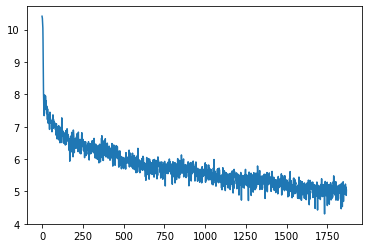

In [130]:
plt.plot(losses)

In [161]:
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch_bilstm, num_workers=8)

evaluate(model, test_dl)

323.59962259115355

In [141]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [154]:
model.load_state_dict(torch.load('drive/My Drive/best_model_wiki'))

<All keys matched successfully>

![Results on dataset](https://c1.sfdcstatic.com/content/dam/web/en_us/www/images/einstein/publications/wikitext-2.png)

Steps for improvement
- Use a larger dataset.
- Preprocess the dataset for artifacts and use a smarter splitting to documents and/or sentences.
- Check any of the papers above or other papers for parameters that work best on the dataset you've chosen
- Use the packing technique to tell the RNN to avoid making steps over padding tokens

### Generation of text



In [157]:
states = (torch.zeros(lstm_layers, 1, lstm_dim).to(device),
              torch.zeros(lstm_layers, 1, lstm_dim).to(device))

sentence_start = 'Robert is the name of a famous'
unk_token_id = vocabulary.word2idx['<unk>']
new_token = None

while new_token != '<eos>' and len(sentence_start.split()) < 29:
  tokens = sentence_start.split()
  token_idx = len(tokens)

  tokens = tokens + ['<pad>'] * (seq_len - len(tokens))

  token_ids = [vocabulary.word2idx.get(token,unk_token_id) for token in tokens]
  batch = collate_batch_bilstm([token_ids])

  logits, states = model(batch[0].to(device), states)
  logits = logits.detach().cpu().numpy()[token_idx]
  

  new_token_id = np.argmax(logits)
  new_token = vocabulary.idx2word[new_token_id]
  sentence_start = sentence_start + ' ' + new_token
  print('\r'+sentence_start, end='')

Robert is the name of a famous series " " " " " " " " " " " " " " " " " " " " "

## Check perplexity of a sentence

In [158]:
def get_sentence_perplexity(sentence, model, vocabulary, seq_len):
  states = (torch.zeros(lstm_layers, 1, lstm_dim).to(device),
              torch.zeros(lstm_layers, 1, lstm_dim).to(device))
  unk_token_id = vocabulary.word2idx['<unk>']

  tokens = sentence.split()
  tokens = tokens[:seq_len]
  tokens = tokens + ['<pad>'] * (seq_len - len(tokens))
  token_ids = [vocabulary.word2idx.get(token,unk_token_id) for token in tokens]

  batch = collate_batch_bilstm([token_ids])
  loss_fn = torch.nn.CrossEntropyLoss()
  logits, states = model(batch[0].to(device), states)
  loss = loss_fn(logits, batch[1].to(device).reshape(-1))
  loss = loss.detach().cpu().numpy()
  return np.exp(loss)

In [159]:
get_sentence_perplexity('I want to buy some potatoes from the airport.', model, vocabulary, seq_len)

4.8525624

In [160]:
get_sentence_perplexity('jibberish ? . something something is', model, vocabulary, seq_len)

6.7407804

References:
- Bucket Iterator https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator
- Packing https://github.com/HarshTrivedi/packing-unpacking-pytorch-minimal-tutorial